This file contains the code to generate the plots of the article "Non-parametric hazard rate estimation with associated kernels
and minimax bandwidth choice." by L. Breuil and S. Kaakai

In [1]:
#install.packages(ggplot2)
#install.packages('IBMPopSim')
#install.packages('viridis')
#install.packages('logKDE')
#install.packages('TeachingDemos')

In [ ]:
#Importing libraries
library("ggplot2")
library('IBMPopSim')
library("viridis")
library('logKDE')
library('TeachingDemos')

source('Assoc_kernel_estimation_functions.R')#R file with base functions

mycol <- rgb(128, 128, 128, max = 255, alpha = 75, names = "lt.grey")
col_pop =  rgb(red = 0.5,green = 0.5, blue = 0.5,alpha = 0.06)

The goal of hazard rate estimation is to estimate, from the jumping times $(\tau_i)_{1\leq i \leq m}$, the hazard rate $k$ associated to these jumping times on $\mathbb{R}_+$.
In order to estimate a hazard rate $k$ of the data $(\tau_i)_{1\leq i \leq m}$ at a given point $t$, one considers the following kernel estimator 
\begin{equation}
   \hat{k}_m(t) =  \sum_{i\geq 1} \frac{1}{m-N_{\tau_i}^-} \kappa_{t,b}(\tau_i),
\end{equation}
where 
\begin{equation}
    N_t = \sum_{i=1}^{m} \mathbb{1}_{( \tau_i \leq  t)}.
\end{equation}

# Kernel presentation (Section 2)

The Gaussian kernel is defined for $b>0$, $y,t \in \mathbb{R}$, 

\begin{equation}
        \kappa_{t,b}(y) = \frac{1}{\sqrt{2 \pi} b} e^{-\frac{(t-y)^2}{2b^2}}
\end{equation}

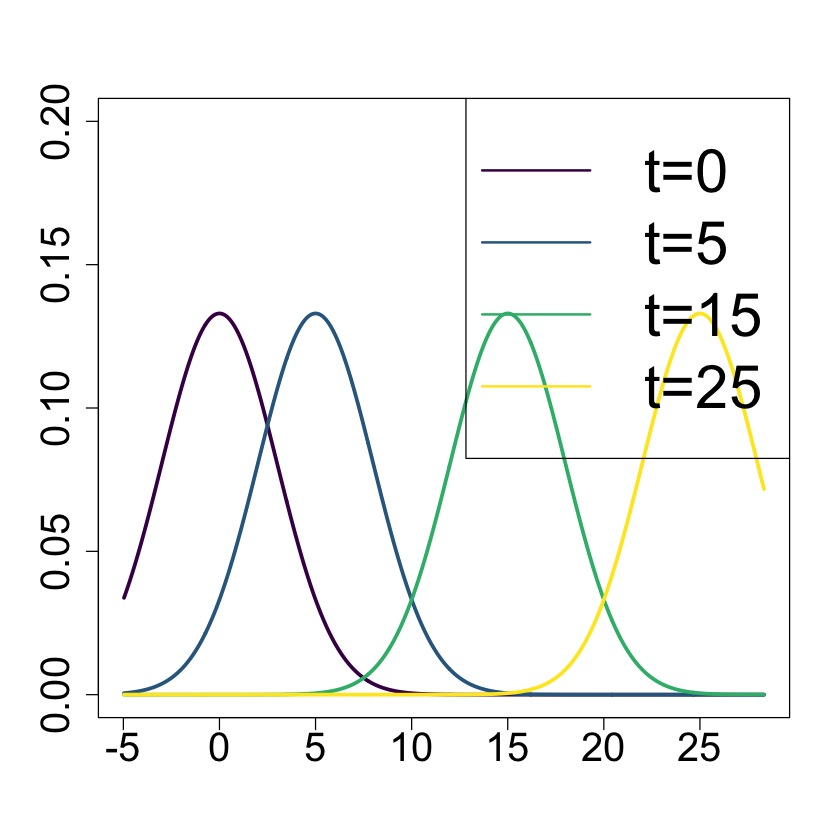

In [5]:
#Plot of the gaussian kernel for different values of t

#pdf(file = "Gauss_kernel.pdf",  width = 10, height = 10) 

T = (1:1000)/30 -5 #grid for y
h = 3 #bandwidth
y = c(0,5,15,25) #times t on which the kernel depends
col_plot = viridis(length(y)) #colors for plot 

plot(T,1/h*dnorm((T-y[1])/h, 0 , 1) , type = 'l' , col= col_plot[1] ,lwd= 3,xlab=NA,ylab =NA,ylim=c(0,0.2),cex.axis = 2, cex.lab =2 )   
lines(T,1/h*dnorm((T-y[2])/h, 0 , 1), col= col_plot[2],lwd=3 )   
lines(T,1/h*dnorm((T-y[3])/h, 0 , 1), col= col_plot[3] ,lwd=3)   
lines(T,1/h*dnorm((T-y[4])/h, 0 , 1) , col= col_plot[4] ,lwd=3)   
legend('topright',legend=c('t=0','t=5','t=15', 't=25'),
        col=col_plot, pch=NA,lty = 1,lwd=2,cex=3)
#dev.off()

The Gamma kernel is defined for $b>0$, $y,t \in \mathbb{R}_+$, 
\begin{equation}
        \kappa_{t,b}(y) = \frac{y^{\rho(t)_b - 1}e^{-y/b}}{b^{\rho(t)_b}\Gamma(\rho(t)_b)} 
    \end{equation}
    where 
    \begin{equation}
    \rho(t)_b = 
    \begin{cases}
         &t/b \text{ if } t \geq 2b\\
         &\frac{1}{4}(t/b)^2 + 1  \text{ if } 0 \leq t < 2b.
    \end{cases}
    \end{equation}

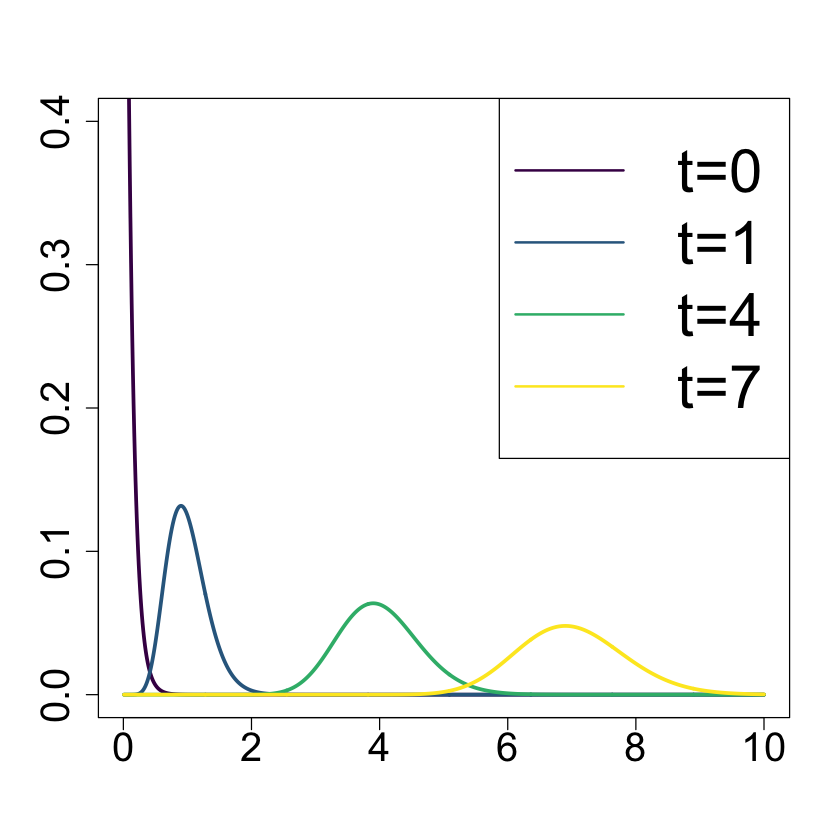

In [8]:
#Plot of the gamma kernel for different values of t

#pdf(file = "Gamma_kernel.pdf",  width = 10, height = 10) 

T = (1:1000)/100 #grid for y
h = 0.1 #bandwidth
y = c(0,1,4,7) #times t on which the kernel depends
col_plot = viridis(length(y)) #colors for plot

#intermediate arrays to compute the gamma kernel
indices = (y >= 2*h)
y_new = y/h*indices + (1/4*(y/h)^2 + 1)*(!indices)

plot(T,h*dgamma(T, y_new[1] , scale = h) , type = 'l' , col= col_plot[1] ,lwd= 3,xlab=NA,ylab =NA ,ylim = c(0,0.4),cex.axis = 2, cex.lab =2)   
lines(T,h*dgamma(T, y_new[2], scale = h), col= col_plot[2],lwd=3 )   
lines(T,h*dgamma(T, y_new[3] , scale = h), col= col_plot[3] ,lwd=3)   
lines(T,h*dgamma(T, y_new[4] , scale = h) , col= col_plot[4] ,lwd=3)   
legend('topright',legend=c('t=0','t=1','t=4', 't=7'),
        col=col_plot, pch=NA,lty = 1,lwd=2,cex=3)
#dev.off()

# Hazard rate estimation with the Gamma kernel: simulated data (section 5.1)

## Comparison of the Gamma kernel estimator with other estimators on two hazard rates

### Exponential hazard rate (figure 2a)

In [13]:
Grid = 0:600

In [15]:
# Data simulation with IBMPopSim 
#death hazard rate is a+b*exp(-c*t)
a = 7*10^(-3)
b = 3*10^(-2)
c = 7*10^(-2)
th_haz = a+b*exp(-c*Grid)
b3 = 0.5 #bandwidth for log estimator
pop_size = 2000 #Simulated population size
param = list('a' = a, 'b' = b, 'c' = c) 
hazard = '{result = a+b*exp(-c*pow(I.age(t),1));}'
seed =1
#Simulation with IBMPopSim: 

pop_init <- population(data.frame( birth = rep(0, pop_size), 
                                     death = NA))
death <- mk_event_individual(type = 'death', 
                              intensity_code = hazard)
model_death <- mk_model(characteristics = get_characteristics(pop_init),
                          events = list(death),
                          parameters = param)
sim_out <- popsim(model = model_death, initial_population = pop_init,
                    events_bounds = c('death' = a+b),
                    parameters = param,
                    time = 2000, seed = seed)

data<- sim_out$population$death #simulated data

In [19]:
#Comparison of the gamma, gaussian kernel (with fixed and nearest neighbour bandwidth) 
#and lognormal kernel with ratio estimator 

#Global estimators 

# Gamma kernel 
B1 = Bandwidth_set_global(pop_size) #bandwidth set for global minimax bandwidth 
RES = minimax_global(data,  Grid, B1)
Bopt_f = RES$B #chosen bandwidth
cat('Global minimax bandwidth:', Bopt_f,'\n')
est_gam_f = sapply(Grid, function(t)(ker_est_gamma_c(t,data,Bopt_f))) #global minmax bandwidth gamma estimator

# Gaussian kernel with cross-validation bandwith               
CV_gs=crossval(sort(data),(1:10),ker_estg,1) #cross-validation for gaussian kernel
b_gs = which.min(CV_gs) #minimizer of cross-validation for gaussian kernel 
cat('Cross-validation bandwidth:',b_gs)
est_gaus = sapply(Grid, function(t)(ker_estg(t,data,b_gs))) #gaussian kernel estimator     

# Ratio estimator with lognormal kernel  
Grid_log=c(0.1, 1:600)
est_log = sapply(Grid_log, function(x)(log_ker_dens(x,b3,data))) #lognormal kernel estimator of density
Surv_log = 1-sapply(Grid_log, function(x)(est_surv(x,b3,data))) # empirical survival function for lognormal kernel ratio estimation

#Local estimators 

# Gamma kernel with local minimax bandwith 
B = Bandwidth_set(pop_size)  #bandwidth set for local minimax bandwidth 
RES = minimax_pointwise(data,  Grid, B)
K_gamma_l = RES$K #adaptive hazard estimator
Bopt_l = RES$B #chosen bandwidth

# Gaussian kernel estimator with nearest neighbour bandwidth    
est_band = sapply(Grid, function(x)(ker_est_neigh(x,data,50)))



Global minimax bandwidth: 0.5732641 
Cross-validation bandwidth: 10

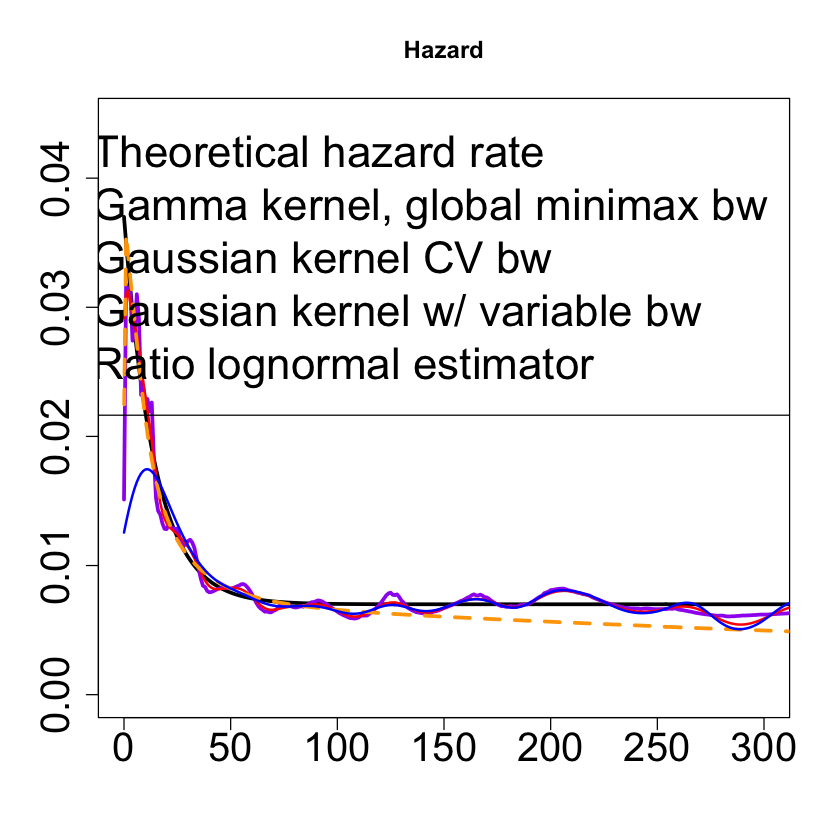

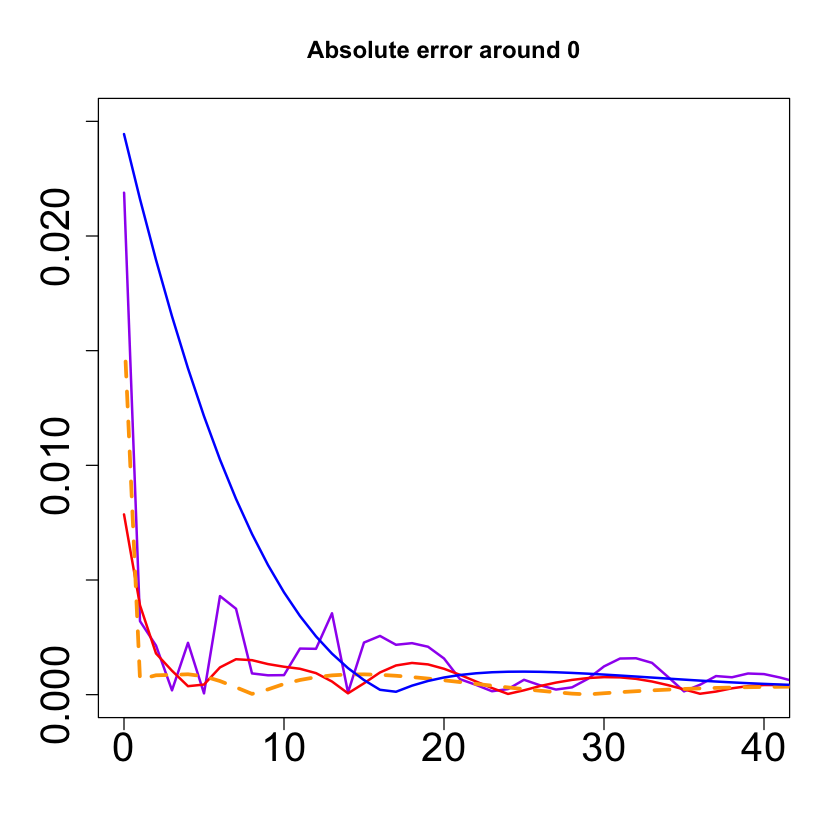

In [23]:
#Plot figure 2.a)
#pdf(file = "Comp_ker_1_l.pdf",  width = 20, height = 10)  

#par(mfrow = c(1,2),cex.lab = 2, cex.axis = 2,cex.main = 2)
plot(Grid, th_haz,lwd=3,type = 'l',lty=1, col = 'black',xlab = NA,
      ylab=NA,xlim=c(0,300), ylim = c(0,1.2*(a+b)),cex.axis=2,cex.lab=2,main = 'Hazard')
lines(Grid, est_band,col = 'purple',lwd = 3,lty=1,type = 'l')
lines(Grid, est_gam_f, col = 'red',lwd = 2,lty=1)
lines(Grid_log, est_log/Surv_log, col = 'orange',lwd = 3,lty=2)
lines(Grid, est_gaus, col = 'blue',lwd = 2,lty=1)

legend('topright',legend=c('Theoretical hazard rate','Gamma kernel, global minimax bw ','Gaussian kernel CV bw',
                           'Gaussian kernel w/ variable bw','Ratio lognormal estimator'),
        col=c('black','red','blue','purple','orange'), pch=c(NA,NA,NA,NA),lty = c(1,1,1,1,2),lwd=3,cex=2.2)


plot(Grid, (abs(est_band-th_haz)),col = 'purple',lwd = 2,lty=1,type = 'l',xlab = NA,
      ylab=NA,xlim=c(0,40),cex.axis=2,cex.lab=2,main = 'Absolute error around 0',ylim=c(0,0.025))
lines(Grid, (abs(est_gam_f-th_haz)), col = 'red',lwd = 2,lty=1)
lines(Grid_log, (abs(est_log/Surv_log-th_haz)), col = 'orange',lwd = 3,lty=2)
lines(Grid, (abs(est_gaus-th_haz)), col = 'blue',lwd = 2,lty=1)
           
#dev.off() 

### Hazard rate choice :  figure 2.b)

In [21]:
#death hazard rate is abs(b2*(t/d2 -c2))/a2
a2 = 100
b2 = 3*10^(-2)
c2 = 30
d2 = 3
param2 = list('a2' = a2,'b2' = b2,'c2' = c2,'d2' = d2) 
hazard2 = '{result = b2*abs(I.age(t)/d2 - c2)/a2;}'
th_hazv = abs(b2*(Grid/d2-c2))/a2
b3 = 0.1 #bandwidth for log estimator
pop_size = 2000 #Simulated population size
seed=1


pop_init <- population(data.frame( birth = rep(0, pop_size), 
                                     death = NA))
death <- mk_event_individual(type = 'death', 
                              intensity_code = hazard2)

model_death2 <- mk_model(characteristics = get_characteristics(pop_init),
                          events = list(death),
                          parameters = param2)

sim_out <- popsim(model = model_death2, initial_population = pop_init,
                    events_bounds = c('death' = 0.1),
                    parameters = param2,
                    time = 2000, seed = seed)

data<- sim_out$population$death #simulated data

In [25]:
#Comparison of the gamma, gaussian kernel (with fixied and nearest neighbour bandwidth) 
#and lognormal kernel with ratio estimator 

#Global estimators 

# Gamma kernel 
B1 = Bandwidth_set_global(pop_size) #bandwidth set for global minimax bandwidth 
RES = minimax_global(data,  Grid, B1)
Bopt_f = RES$B #chosen bandwidth
cat('Global minimax bandwidth:', Bopt_f,'\n')
est_gam_f = sapply(Grid, function(t)(ker_est_gamma_c(t,data,Bopt_f))) #global minmax bandwidth gamma estimator

# Gaussian kernel with cross-validation bandwith               
CV_gs=crossval(sort(data),(1:10),ker_estg,1) #cross-validation for gaussian kernel
b_gs = which.min(CV_gs) #minimizer of cross-validation for gaussian kernel 
cat('Cross-validation bandwidth:',b_gs)
est_gaus = sapply(Grid, function(t)(ker_estg(t,data,b_gs))) #gaussian kernel estimator     

# Ratio estimator with lognormal kernel
est_log = sapply(Grid_log, function(x)(log_ker_dens(x,b3,data))) #lognormal kernel estimator of density
Surv_log = 1-sapply(Grid_log, function(x)(est_surv(x,b3,data))) # empirical survival function for lognormal kernel ratio estimation

#Local estimators 

# Gamma kernel with local minimax bandwith 
B = Bandwidth_set(pop_size)  #bandwidth set for local minimax bandwidth 
RES = minimax_pointwise(data,  Grid, B)
K_gamma_l = RES$K #adaptive hazard estimator
Bopt_l = RES$B #chosen bandwidth

# Gaussian kernel estimator with nearest neighbour bandwidth    
est_band = sapply(Grid, function(x)(ker_est_neigh(x,data,50)))   


Global minimax bandwidth: 0.006299605 
Cross-validation bandwidth: 10

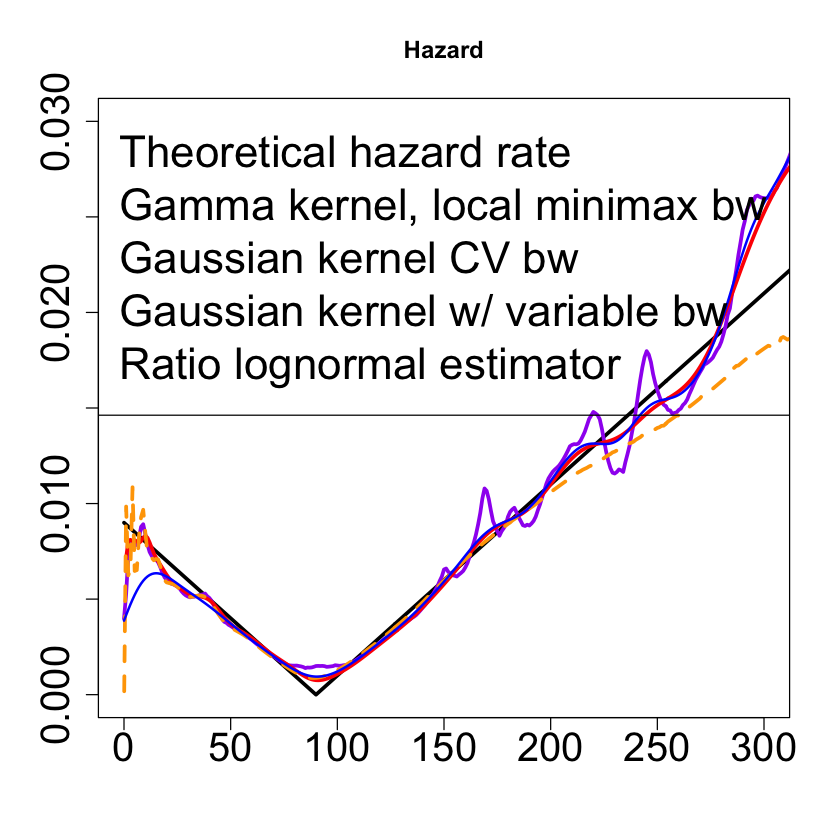

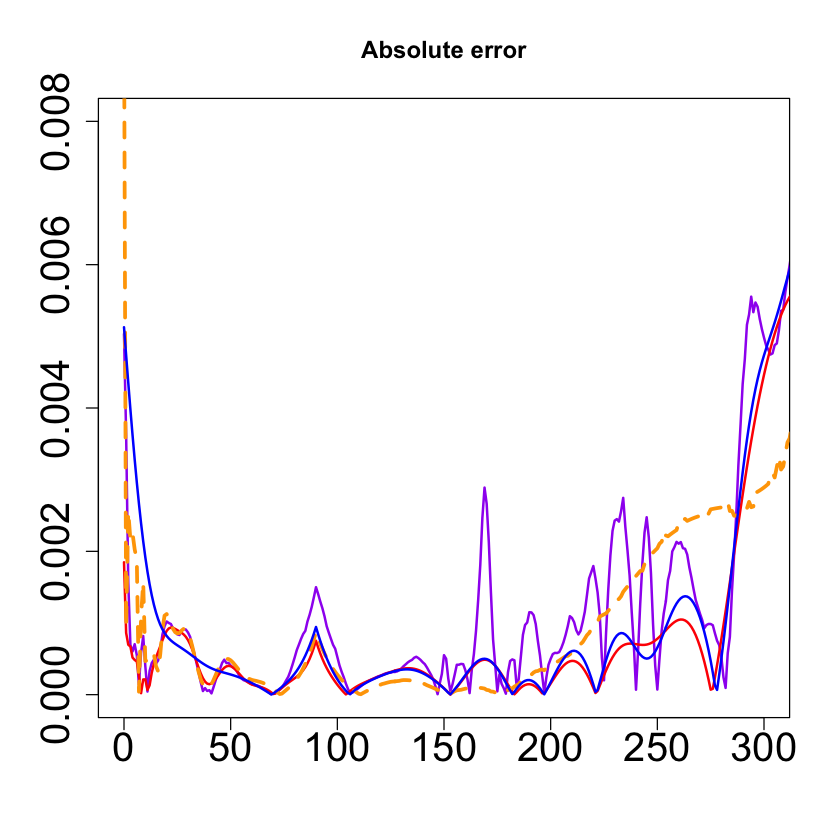

In [26]:
#Plot Figure 2.b)

#pdf(file = "Comp_ker_C0_1.pdf",  width = 20, height = 10)  
#par(mfrow = c(1,2),cex.lab = 2, cex.axis = 2,cex.main = 2)


plot(Grid, th_hazv,lwd=3,type = 'l',lty=1, col = 'black',xlab = NA,
      ylab=NA,xlim=c(0,300), ylim = c(0,b),cex.axis=2,cex.lab=2,main = 'Hazard')
lines(Grid, est_band,col = 'purple',lwd = 3,lty=1,type = 'l')
lines(K_gamma_l, col = 'red',lwd = 3,lty=1)
lines(Grid_log, est_log/Surv_log, col = 'orange',lwd = 3,lty=2)
lines(Grid, est_gaus, col = 'blue',lwd = 2,lty=1)

legend('topright',legend=c('Theoretical hazard rate','Gamma kernel, local minimax bw ','Gaussian kernel CV bw',
                           'Gaussian kernel w/ variable bw','Ratio lognormal estimator'),# 'Experimental survival function'),
        col=c('black','red','blue','purple','orange'), pch=c(NA,NA,NA,NA),lty = c(1,1,1,1,2),lwd=3,cex=2.2)

                  
plot(Grid, (abs(est_band-th_hazv)),col = 'purple',lwd = 2,lty=1,type = 'l',xlab = NA,
      ylab=NA,xlim=c(0,300),cex.axis=2,cex.lab=2,main = 'Absolute error',ylim=c(0,0.008))
lines(Grid, abs(K_gamma_l-th_hazv), col = 'red',lwd = 2,lty=1)
lines(Grid_log, abs(est_log/Surv_log-th_hazv), col = 'orange',lwd = 3,lty=2)
lines(Grid, (abs(est_gaus-th_hazv)), col = 'blue',lwd = 2,lty=1)
           
#dev.off() 

## MISE AND MSE at 0 (tables 1 and 2 )

In [29]:
#death hazard rate is a1+b1*exp(-c1*t)
a1 = 7*10^(-3)
b1 = 3*10^(-2)
c1 = 7*10^(-2)
param1 = list('a1'= a1, 'b1'=b1, 'c1'= c1) #parameters in list form
Grid = (0:600) #grid 
th_haz = a1+b1*exp(-c1*Grid) #theoretical hazard rate 
reps = 50 #number of repetitions to compute empirical MISE
hazard1 = '{result = a1+b1*exp(-c1*pow(I.age(t),1));}' #theoretical hazard rate expression 
grid_max = 601 #maximum index of Grid for computation of MISE

### Gaussian kernel 

In [32]:
# Code to compute the empirical MISE for the local minimax bandwidth and nearest neighbour bandwidth, takes a while, 
# the following cell allows to just load the results
compute_data = FALSE # set to TRUE to recompute all of the MISE estimations, takes a few hours
if (compute_data){
  MISE_gauss_500 = MISE_approx_gaussian(500, reps ,param1, hazard1,th_haz,Grid,25,BW_CV) # last input is number of neighbours for nearest
  # neighbour bandwidth 
  MISE_500_cvg = rowSums(MISE_gauss_500$cv[,1:grid_max])
  MISE_500_nng = rowSums(MISE_gauss_500$nn[,1:grid_max])
  MISE_500_cv_0g = MISE_gauss_500$cv[,1]
  MISE_500_nn_0g = MISE_gauss_500$nn[,1]
    
  MISE_gauss_1000 = MISE_approx_gaussian(1000, reps ,param1, hazard1,th_haz,Grid,40,BW_CV)
  MISE_1000_cvg = rowSums(MISE_gauss_1000$cv[,1:grid_max])
  MISE_1000_nng = rowSums(MISE_gauss_1000$nn[,1:grid_max])
  MISE_1000_cv_0g = MISE_gauss_1000$cv[,1]
  MISE_1000_nn_0g = MISE_gauss_1000$nn[,1]
  
  MISE_gauss_2000 = MISE_approx_gaussian(2000, reps ,param1, hazard1,th_haz,Grid,60,BW_CV)
  MISE_2000_cvg = rowSums(MISE_gauss_2000$cv[,1:grid_max])
  MISE_2000_nng = rowSums(MISE_gauss_2000$nn[,1:grid_max])
  MISE_2000_cv_0g = MISE_gauss_2000$cv[,1]
  MISE_2000_nn_0g = MISE_gauss_2000$nn[,1]
  
  MISE_gauss_4000 = MISE_approx_gaussian(4000, reps ,param1, hazard1,th_haz,Grid,70,BW_CV)
  MISE_4000_cvg = rowSums(MISE_gauss_4000$cv[1:grid_max,])
  MISE_4000_nng = rowSums(MISE_gauss_4000$nn[1:grid_max,])
  MISE_4000_cv_0g = MISE_gauss_4000$cv[,1]
  MISE_4000_nn_0g = MISE_gauss_4000$nn[,1]
} else{
  # load results 
  MISE_500_cvg = rowSums(read.csv('MISE/MISE_500_cvg.csv')[2:(grid_max+1)])
  MISE_500_nng = rowSums(read.csv('MISE/MISE_500_nng.csv')[2:(grid_max+1)])
  MISE_500_cv_0g = read.csv('MISE/MISE_500_cvg.csv')$V1
  MISE_500_nn_0g = read.csv('MISE/MISE_500_nng.csv')$V1
  
  MISE_1000_cvg = rowSums(read.csv('MISE/MISE_1000_cvg.csv')[2:(grid_max+1)])
  MISE_1000_nng = rowSums(read.csv('MISE/MISE_1000_nng.csv')[2:(grid_max+1)])
  MISE_1000_cv_0g = read.csv('MISE/MISE_1000_cvg.csv')$V1
  MISE_1000_nn_0g = read.csv('MISE/MISE_1000_nng.csv')$V1
  
  MISE_2000_cvg = rowSums(read.csv('MISE/MISE_2000_cvg.csv')[2:(grid_max+1)])
  MISE_2000_nng = rowSums(read.csv('MISE/MISE_2000_nng.csv')[2:(grid_max+1)])
  MISE_2000_cv_0g = read.csv('MISE/MISE_2000_cvg.csv')$V1
  MISE_2000_nn_0g = read.csv('MISE/MISE_2000_nng.csv')$V1
  
  MISE_4000_cvg = rowSums(read.csv('MISE/MISE_4000_cvg.csv')[2:(grid_max+1)])
  MISE_4000_nng = rowSums(read.csv('MISE/MISE_4000_nng.csv')[2:(grid_max+1)])
  MISE_4000_cv_0g = read.csv('MISE/MISE_4000_cvg.csv')$V1
  MISE_4000_nn_0g = read.csv('MISE/MISE_4000_nng.csv')$V1   
}


In [33]:
#print results Gaussian kenrel 
print('500 ')
cat(' nn : ',mean(MISE_500_nng),' ',sd(MISE_500_nng),' nn 0: ',mean(MISE_500_nn_0g),' ', sd(MISE_500_nn_0g),'\n')
cat(' cv: ', mean(MISE_500_cvg),' ',sd(MISE_500_cvg),' cv 0: ', mean(MISE_500_cv_0g), ' ', sd(MISE_500_cv_0g),'\n')
print('1000 ')
cat(' nn : ',mean(MISE_1000_nng),' ',sd(MISE_1000_nng),' nn 0: ',mean(MISE_1000_nn_0g),' ', sd(MISE_1000_nn_0g),'\n')
cat(' cv: ', mean(MISE_1000_cvg),' ',sd(MISE_1000_cvg),' cv 0: ', mean(MISE_1000_cv_0g), ' ', sd(MISE_1000_cv_0g),'\n')
print('2000 ')
cat(' nn : ',mean(MISE_2000_nng),' ',sd(MISE_2000_nng),' nn 0: ',mean(MISE_2000_nn_0g),' ', sd(MISE_2000_nn_0g),'\n')
cat(' cv: ', mean(MISE_2000_cvg),' ',sd(MISE_2000_cvg),' cv 0: ', mean(MISE_2000_cv_0g), ' ', sd(MISE_2000_cv_0g),'\n')
print('4000 ')
cat(' nn : ',mean(MISE_4000_nng),' ',sd(MISE_4000_nng),' nn 0: ',mean(MISE_4000_nn_0g),' ', sd(MISE_4000_nn_0g),'\n')
cat(' cv: ', mean(MISE_4000_cvg),' ',sd(MISE_4000_cvg),' cv 0: ', mean(MISE_4000_cv_0g), ' ', sd(MISE_4000_cv_0g),'\n')

[1] "500 "
 nn :  0.001657573   0.000774681  nn 0:  0.0003767868   0.0001260366 
 cv:  0.008258826   0.002584415  cv 0:  0.0008896975   7.967202e-05 
[1] "1000 "
 nn :  0.001083892   0.0003647904  nn 0:  0.0003533572   9.009934e-05 
 cv:  0.007366353   0.002042456  cv 0:  0.0008592621   0.0001424433 
[1] "2000 "
 nn :  0.0007981287   0.0001836395  nn 0:  0.0003582882   7.486174e-05 
 cv:  0.007372331   0.005279109  cv 0:  0.0008564558   0.0001423199 
[1] "4000 "
 nn :  0.0007349298   0.0002028832  nn 0:  0.0003545749   6.812285e-05 
 cv:  0.006256865   0.001364136  cv 0:  0.0008670811   0.0001231937 


### Gamma kernel with different bandwith choice

In [35]:
#Code to compute the empirical MISE for the gamma kernel 
#local minimax bandwidth and nearest neighbour bandwidth, takes a long time. 

compute_data = FALSE #set to TRUE to recompute all of the MISE estimations else load the results 
if (compute_data){
MISE_loc_500 = MISE_approx_local(500, reps ,param1, hazard1,th_haz,Grid,25) #last input is number of neighbours for nearest
#neighbour bandwidth 
MISE_500_mx = rowSums(MISE_loc_500$mx[,1:grid_max])
MISE_500_nn = rowSums(MISE_loc_500$nn[,1:grid_max])
MISE_500_mx_0 = MISE_loc_500$mx[,1]
MISE_500_nn_0 = MISE_loc_500$nn[,1]

MISE_loc_1000 = MISE_approx_local(1000, reps ,param1, hazard1,th_haz,Grid,40)
MISE_1000_mx = rowSums(MISE_loc_1000$mx[,1:grid_max])
MISE_1000_nn = rowSums(MISE_loc_1000$nn[,1:grid_max])
MISE_1000_mx_0 = MISE_loc_1000$mx[,1]
MISE_1000_nn_0 = MISE_loc_1000$nn[,1]

MISE_loc_2000 = MISE_approx_local(2000, reps ,param1, hazard1,th_haz,Grid,60)
MISE_2000_mx = rowSums(MISE_loc_2000$mx[,1:grid_max])
MISE_2000_nn = rowSums(MISE_loc_2000$nn[,1:grid_max])
MISE_2000_mx_0 = MISE_loc_2000$mx[,1]
MISE_2000_nn_0 = MISE_loc_2000$nn[,1]

MISE_loc_4000 = MISE_approx_local(4000, reps ,param1, hazard1,th_haz,Grid,70)
MISE_4000_mx = rowSums(MISE_loc_4000$mx[,1:grid_max])
MISE_4000_nn = rowSums(MISE_loc_4000$nn[,1:grid_max])
MISE_4000_mx_0 = MISE_loc_4000$mx[,1]
MISE_4000_nn_0 = MISE_loc_4000$nn[,1]
} else {
MISE_500_mx=rowSums(read.csv('MISE/MISE_500_mx.csv')[2:(grid_max+1)])
MISE_500_nn=rowSums(read.csv('MISE/MISE_500_nn.csv')[2:(grid_max+1)])
MISE_500_mx_0=read.csv('MISE/MISE_500_mx.csv')$V1
MISE_500_nn_0=read.csv('MISE/MISE_500_nn.csv')$V1

MISE_1000_mx=rowSums(read.csv('MISE/MISE_1000_mx.csv')[2:(grid_max+1)])
MISE_1000_nn=rowSums(read.csv('MISE/MISE_1000_nn.csv')[2:(grid_max+1)])
MISE_1000_mx_0=read.csv('MISE/MISE_1000_mx.csv')$V1
MISE_1000_nn_0=read.csv('MISE/MISE_1000_nn.csv')$V1

MISE_2000_mx=rowSums(read.csv('MISE/MISE_2000_mx.csv')[2:(grid_max+1)])
MISE_2000_nn=rowSums(read.csv('MISE/MISE_2000_nn.csv')[2:(grid_max+1)])
MISE_2000_mx_0=read.csv('MISE/MISE_2000_mx.csv')$V1
MISE_2000_nn_0=read.csv('MISE/MISE_2000_nn.csv')$V1

MISE_4000_mx=rowSums(read.csv('MISE/MISE_4000_mx.csv')[2:(grid_max+1)])
MISE_4000_nn=rowSums(read.csv('MISE/MISE_4000_nn.csv')[2:(grid_max+1)])
MISE_4000_mx_0=read.csv('MISE/MISE_4000_mx.csv')$V1
MISE_4000_nn_0=read.csv('MISE/MISE_4000_nn.csv')$V1 
}

In [36]:
#Printing out results

print('500 ')
cat(' minimax: ',mean(MISE_500_mx),' ',sd(MISE_500_mx),' minimax 0: ',mean(MISE_500_mx_0),' ', sd(MISE_500_mx_0),'\n')
cat(' nn: ', mean(MISE_500_nn),' ',sd(MISE_500_nn),' nn 0: ', mean(MISE_500_nn_0), ' ', sd(MISE_500_nn_0),'\n')
print('1000')
cat(' minimax: ',mean(MISE_1000_mx),' ',sd(MISE_1000_mx),' minimax 0: ',mean(MISE_1000_mx_0),' ', sd(MISE_1000_mx_0),'\n')
cat(' nn: ', mean(MISE_1000_nn),' ',sd(MISE_1000_nn),' nn 0: ', mean(MISE_1000_nn_0), ' ', sd(MISE_1000_nn_0),'\n')
print('2000')
cat(' minimax: ',mean(MISE_2000_mx),' ',sd(MISE_2000_mx),' minimax 0: ',mean(MISE_2000_mx_0),' ', sd(MISE_2000_mx_0),'\n')
cat(' nn: ', mean(MISE_2000_nn),' ',sd(MISE_2000_nn),' nn 0: ', mean(MISE_2000_nn_0), ' ', sd(MISE_2000_nn_0),'\n')
print('4000')
cat(' minimax: ',mean(MISE_4000_mx),' ',sd(MISE_4000_mx),' minimax 0: ',mean(MISE_4000_mx_0),' ', sd(MISE_4000_mx_0),'\n')
cat(' nn: ', mean(MISE_4000_nn),' ',sd(MISE_4000_nn),' nn 0: ', mean(MISE_4000_nn_0), ' ', sd(MISE_4000_nn_0),'\n')


[1] "500 "
 minimax:  0.006364204   0.008510864  minimax 0:  0.0005154355   0.0009093185 
 nn:  0.001514116   0.0006110967  nn 0:  0.0003634205   0.0001038924 
[1] "1000"
 minimax:  0.0029463   0.002603864  minimax 0:  0.0003963873   0.0006420635 
 nn:  0.001027068   0.0003189039  nn 0:  0.0003763252   8.892416e-05 
[1] "2000"
 minimax:  0.001747498   0.001104122  minimax 0:  0.0003252467   0.0005152173 
 nn:  0.0008039813   0.0001687067  nn 0:  0.0003746545   7.776508e-05 
[1] "4000"
 minimax:  0.00103055   0.0005521959  minimax 0:  0.0002785397   0.0004138676 
 nn:  0.0007310838   0.0001405866  nn 0:  0.0003706283   7.024551e-05 


In [37]:
#Code to compute the empirical MISE on the total interval and the MSE at 0 for the gamma kernel
#global minimax bandwidth  and cross-validation bandwidth

BW_CV = (1:150)/3 #set of bandwidths for cross validation

compute_data = FALSE #set to TRUE to recompute all of the MISE estimations, takes a long time. If FALSE loads the results. 
if (compute_data){
MISE_glob_500 = MISE_approx_global(500, reps ,param1, hazard1,th_haz,Grid,BW_CV) #last input is bandwidth array for CV bandwidth choice
#neighbour bandwidth 
MISE_500_mx_g = rowSums(MISE_glob_500$mx_g[,1:grid_max])
MISE_500_cv = rowSums(MISE_glob_500$cv[,1:grid_max])
MISE_500_mx_g0 = MISE_glob_500$mx_g[,1]
MISE_500_cv_0 = MISE_glob_500$cv[,1]

MISE_glob_1000 = MISE_approx_global(1000, reps ,param1, hazard1,th_haz,Grid,BW_CV)
MISE_1000_mx_g =rowSums(MISE_glob_1000$mx_g[,1:grid_max,])
MISE_1000_cv = rowSums(MISE_glob_1000$cv[,1:grid_max])
MISE_1000_mx_g0 = MISE_glob_1000$mx_g[,1]
MISE_1000_cv_0 =MISE_glob_1000$cv[,1]
    
MISE_glob_2000 = MISE_approx_global(2000, reps ,param1, hazard1,th_haz,Grid,BW_CV)
MISE_2000_mx_g =rowSums( MISE_glob_2000$mx_g[,1:grid_max])
MISE_2000_cv = rowSums(MISE_glob_2000$cv[,1:grid_max])
MISE_2000_mx_g0 = MISE_glob_2000$mx_g[,1]
MISE_2000_cv_0 = MISE_glob_2000$cv[,1]

MISE_glob_4000 = MISE_approx_global(4000, reps ,param1, hazard1,th_haz,Grid,BW_CV)
MISE_4000_mx_g = rowSums(MISE_glob_4000$mx_g[,1:grid_max])
MISE_4000_cv = rowSums(MISE_glob_4000$cv[,1:grid_max])
MISE_4000_mx_g0 = MISE_glob_4000$mx_g[,1]
MISE_4000_cv_0 = MISE_glob_4000$cv[,1]
}else{ #load results 

MISE_500_mx_g=rowSums(read.csv('MISE/MISE_500_mx_g.csv')[2:(grid_max+1)])
MISE_500_cv=rowSums(read.csv('MISE/MISE_500_cv.csv')[2:(grid_max+1)])
MISE_500_mx_g0= read.csv('MISE/MISE_500_mx_g.csv')$V1
MISE_500_cv_0=read.csv('MISE/MISE_500_cv.csv')$V1

MISE_1000_mx_g=rowSums(read.csv('MISE/MISE_1000_mx_g.csv')[2:(grid_max+1)])
MISE_1000_cv=rowSums(read.csv('MISE/MISE_1000_cv.csv')[2:(grid_max+1)])
MISE_1000_mx_g0=read.csv('MISE/MISE_1000_mx_g.csv')$V1
MISE_1000_cv_0=read.csv('MISE/MISE_1000_cv.csv')$V1


MISE_2000_mx_g=rowSums(read.csv('MISE/MISE_2000_mx_g.csv')[2:(grid_max+1)])
MISE_2000_cv=rowSums(read.csv('MISE/MISE_2000_cv.csv')[2:(grid_max+1)])
MISE_2000_mx_g0=read.csv('MISE/MISE_2000_mx_g.csv')$V1
MISE_2000_cv_0=read.csv('MISE/MISE_2000_cv.csv')$V1


MISE_4000_mx_g=rowSums(read.csv('MISE/MISE_4000_mx_g.csv')[2:(grid_max+1)])
MISE_4000_cv=rowSums(read.csv('MISE/MISE_4000_cv.csv')[2:(grid_max+1)])
MISE_4000_mx_g0=read.csv('MISE/MISE_4000_mx_g.csv')$V1
MISE_4000_cv_0=read.csv('MISE/MISE_4000_cv.csv')$V1
   
}

In [38]:
#print results
print('500 ')
cat(' minimax g: ',mean(MISE_500_mx_g),' ',sd(MISE_500_mx_g),' minimax g0: ',mean(MISE_500_mx_g0),' ', sd(MISE_500_mx_g0),'\n')
cat(' cv: ', mean(MISE_500_cv),' ',sd(MISE_500_cv),' cv 0: ', mean(MISE_500_cv_0), ' ', sd(MISE_500_cv_0),'\n')
print('1000 ')
cat(' minimax g: ',mean(MISE_1000_mx_g),' ',sd(MISE_1000_mx_g),' minimax g0: ',mean(MISE_1000_mx_g0),' ', sd(MISE_1000_mx_g0),'\n')
cat(' cv: ', mean(MISE_1000_cv),' ',sd(MISE_1000_cv),' cv 0: ', mean(MISE_1000_cv_0), ' ', sd(MISE_1000_cv_0),'\n')
print('2000 ')
cat(' minimax g: ',mean(MISE_2000_mx_g),' ',sd(MISE_2000_mx_g),' minimax g0: ',mean(MISE_2000_mx_g0),' ', sd(MISE_2000_mx_g0),'\n')
cat(' cv: ', mean(MISE_2000_cv),' ',sd(MISE_2000_cv),' cv 0: ', mean(MISE_2000_cv_0), ' ', sd(MISE_2000_cv_0),'\n')
print('4000 ')
cat(' minimax g: ',mean(MISE_4000_mx_g),' ',sd(MISE_4000_mx_g),' minimax g0: ',mean(MISE_4000_mx_g0),' ', sd(MISE_4000_mx_g0),'\n')
cat(' cv: ', mean(MISE_4000_cv),' ',sd(MISE_4000_cv),' cv 0: ', mean(MISE_4000_cv_0), ' ', sd(MISE_4000_cv_0),'\n')

[1] "500 "
 minimax g:  0.003642999   0.003060173  minimax g0:  4.821066e-05   6.130577e-05 
 cv:  0.003251589   0.003877468  cv 0:  0.0002517074   0.0001866151 
[1] "1000 "
 minimax g:  0.00187208   0.0009930821  minimax g0:  2.838347e-05   4.020061e-05 
 cv:  0.001964263   0.0009794937  cv 0:  0.0002523448   0.0001792553 
[1] "2000 "
 minimax g:  0.001108753   0.0005772393  minimax g0:  2.221601e-05   2.91336e-05 
 cv:  0.001539303   0.001026726  cv 0:  0.000211877   0.0001800336 
[1] "4000 "
 minimax g:  0.0005823134   0.0002792309  minimax g0:  1.377328e-05   1.469893e-05 
 cv:  0.00141862   0.001066798  cv 0:  0.0002136263   0.0001830721 


## Lognormal ratio estimator

In [ ]:
Grid = c(0.1,1:600)
#Code to compute the empirical MISE on the total interval and the MSE at 0 for the lognormal ratio estimator

compute_data = FALSE #set to TRUE to recompute all of the MISE estimations, takes a long time. If FALSE loads the results. 
if (compute_data){
MISE_log_500 = MISE_approx_lognormal(500, reps ,param1, hazard1,th_haz,Grid,0.5) 
MISE_500_log_05 = rowSums(MISE_log_500[,1:grid_max])
MISE_500_log_05_0 = MISE_log_500[,1]

MISE_log_1000 = MISE_approx_lognormal(1000, reps ,param1, hazard1,th_haz,Grid,0.5) 
MISE_1000_log_05 = rowSums(MISE_log_1000[,1:grid_max])
MISE_1000_log_05_0 = MISE_log_1000[,1]
    
MISE_log_2000 = MISE_approx_lognormal(2000, reps ,param1, hazard1,th_haz,Grid,0.5) 
MISE_2000_log_05 = rowSums(MISE_log_2000[,1:grid_max])
MISE_2000_log_05_0 = MISE_log_2000[,1]
    
MISE_log_4000 = MISE_approx_lognormal(4000, reps ,param1, hazard1,th_haz,Grid,0.5) 
MISE_4000_log_05 = rowSums(MISE_log_4000[,1:grid_max])
MISE_4000_log_05_0 = MISE_log_4000[,1]
    
}else{ #load results 
MISE_500_log_05=rowSums(read.csv('MISE_log/MISE_log_m_500_b3_0.5rep50.csv')[1:(grid_max)])
MISE_500_log_05_0=read.csv('MISE_log/MISE_log_m_500_b3_0.5rep50.csv')$V1

MISE_1000_log_05=rowSums(read.csv('MISE_log/MISE_log_m_1000_b3_0.5rep50.csv')[1:(grid_max)])
MISE_1000_log_05_0=read.csv('MISE_log/MISE_log_m_1000_b3_0.5rep50.csv')$V1

MISE_2000_log_05=rowSums(read.csv('MISE_log/MISE_log_m_2000_b3_0.5rep50.csv')[1:(grid_max)])
MISE_2000_log_05_0=read.csv('MISE_log/MISE_log_m_2000_b3_0.5rep50.csv')$V1

MISE_4000_log_05=rowSums(read.csv('MISE_log/MISE_log_m_4000_b3_0.5rep50.csv')[1:(grid_max)])
MISE_4000_log_05_0=read.csv('MISE_log/MISE_log_m_4000_b3_0.5rep50.csv')$V1
   
}

In [ ]:
#print results
print('500 ')
cat(' bw 0.5: ',mean(MISE_500_log_05),' ',sd(MISE_500_log_05),' bw 0.5 0: ',mean(MISE_500_log_05_0),' ', sd(MISE_500_log_05_0),'\n')
print('1000 ')
cat(' bw 0.5: ',mean(MISE_1000_log_05),' ',sd(MISE_1000_log_05),' bw 0.5 0: ',mean(MISE_1000_log_05_0),' ', sd(MISE_1000_log_05_0),'\n')
print('2000 ')
cat(' bw 0.5: ',mean(MISE_2000_log_05),' ',sd(MISE_2000_log_05),' bw 0.5 0: ',mean(MISE_2000_log_05_0),' ', sd(MISE_2000_log_05_0),'\n')
print('4000 ')
cat(' bw 0.5: ',mean(MISE_4000_log_05),' ',sd(MISE_4000_log_05),' bw 0.5 0: ',mean(MISE_4000_log_05_0),' ', sd(MISE_4000_log_05_0),'\n')

## Test of the local minimax bandwidth estimator on simulated data for different hazard rates (Figure 3)

In [40]:
Grid = (0:500)
m=2000 #data size
B = Bandwidth_set(m) 
#parameter values 
a3 = 7*10^(-3)
c3 = 0

hazard3 = '{result = a+ (exp(-pow(I.age(t)-c,2)/(2*pow(b,2)))+exp(-pow(I.age(t)-(c+150),2)/(2*pow(b,2))))/(b*sqrt(2*3.14));}'
seed=1 #seed for reproducability 

#parameter b changes for each hazard rate 

# First case 
b3 = 15
param3 = list('a' = a3, 'c' = c3,'b' = b3)
th_haz1= dnorm(Grid, c3, b3)+a3 + dnorm(Grid, c3+150, b3) #hazard is a mix of gaussians

# Simulation 
pop_init <- population(data.frame( birth = rep(0, m), death = NA))
death <- mk_event_individual(type = 'death', intensity_code = hazard3)
model_death3 <- mk_model(characteristics = get_characteristics(pop_init),
                          events = list(death),
                          parameters = param3)
sim_out <- popsim(model = model_death3, initial_population = pop_init,
                    events_bounds = c('death' = 0.2),
                    parameters = param3,
                    time = 2000, seed=seed)

data1<- sim_out$population$death #simulated data

# Estimation 
RES = minimax_pointwise(data1,  Grid, B) #minimax bandwidth estimator
Koptc1 = RES$K #adaptive hazard estimator
Boptc1 = RES$B #chosen bandwidth

# Second case 
param3$b = 5 
sim_out <- popsim(model = model_death3, initial_population = pop_init,
                    events_bounds = c('death' = 0.2),
                    parameters = param3,
                    time = 2000,seed=seed)
data2 <- sim_out$population$death #simulated data
th_haz2= dnorm(Grid, c3, param3$b)+a3 + dnorm(Grid, c3+150, param3$b)#hazard is a mix of gaussians
RES = minimax_pointwise(data2,  Grid, B)#minimax bandwidth estimator
Koptc2= RES$K
Boptc2 = RES$B

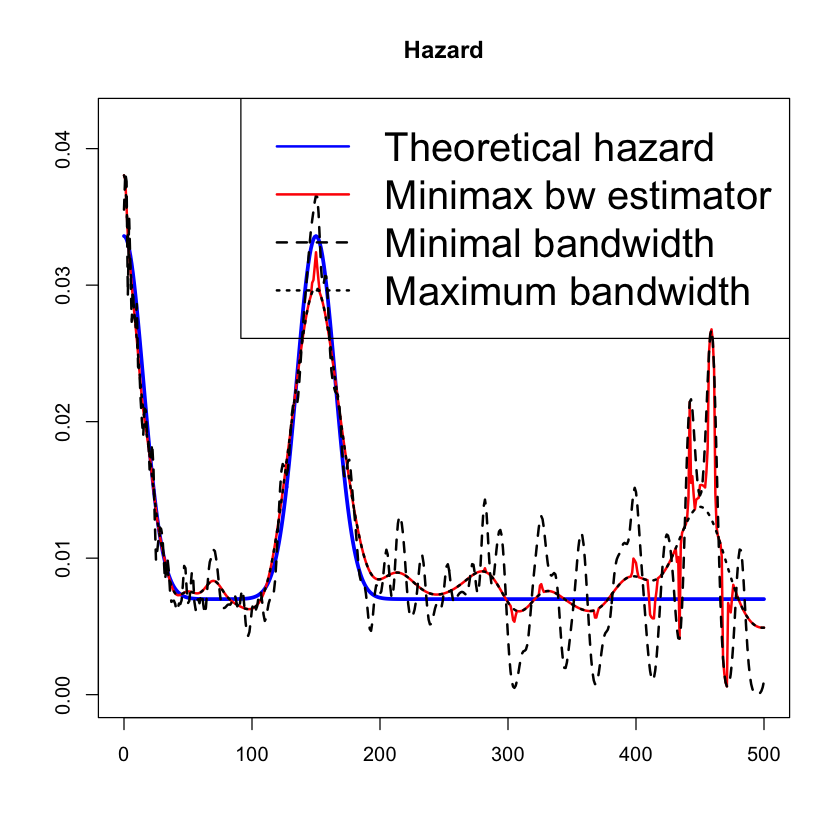

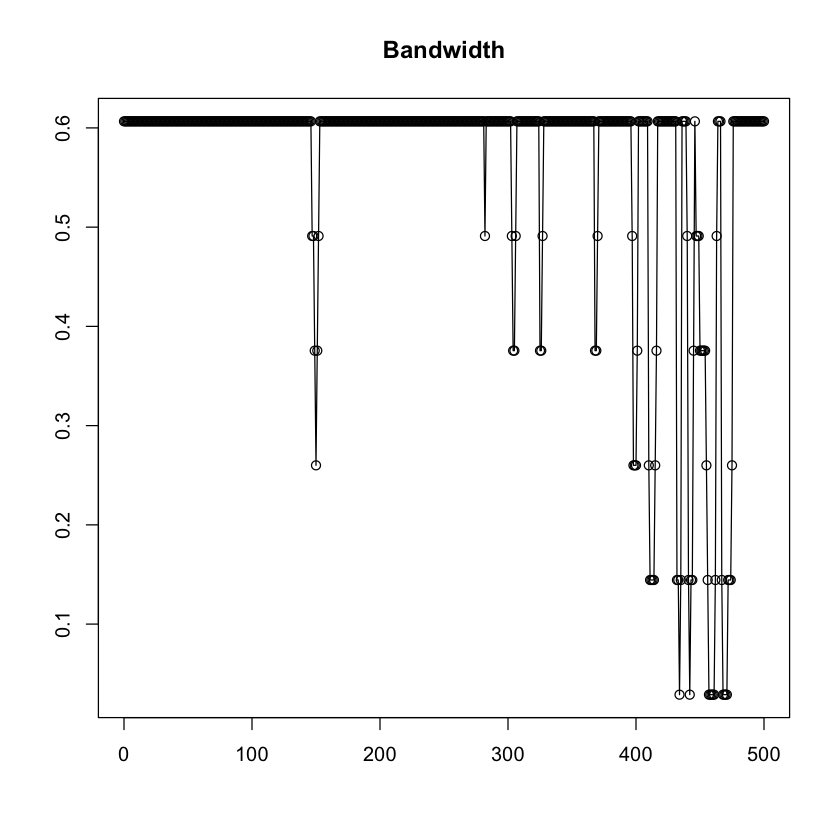

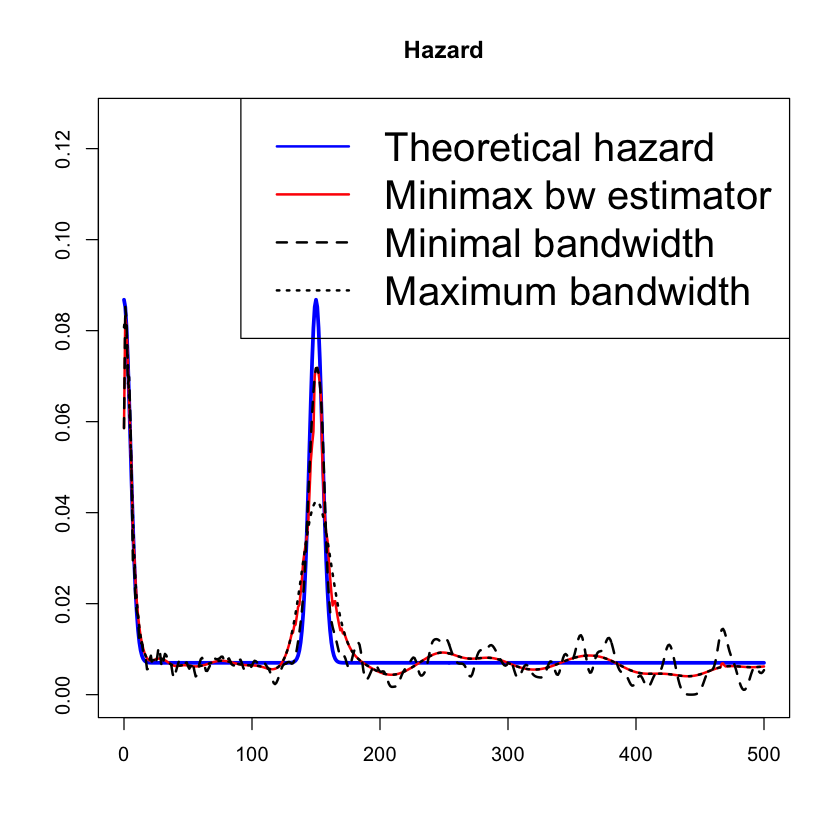

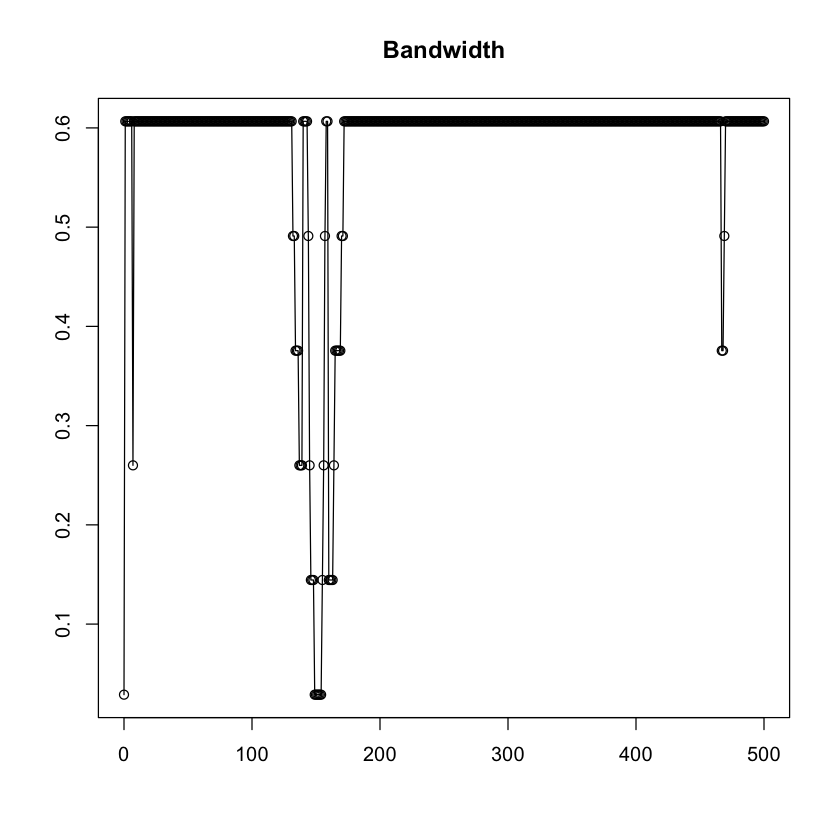

In [46]:
# plot Figure 5
#pdf(file = "Oracle_diff_haz_2.pdf",  width = 17, height = 5) 

#par(cex.lab = 2, cex.axis = 2,cex.main = 2)


#par(mfrow = c(1,4))
plot(Grid, th_haz1,col='blue',lwd=3,type = 'l',lty=1,ylim=c(0,6*a3),ylab = NA, main = 'Hazard',xlab = NA)
lines(Grid,Koptc1, type = 'l',col='red',lwd=2)
test = sapply(Grid, function(t)(ker_est_gamma_c(t,data1,min(B))))
lines(Grid,  test, col='black',lty=2,lwd=2)   
test = sapply(Grid, function(t)(ker_est_gamma_c(t,data1,max(B))))
lines(Grid,  test, col='black',lty=3,lwd=2)   
legend('topright',legend=c('Theoretical hazard', 'Minimax bw estimator', 'Minimal bandwidth', 'Maximum bandwidth')
       , col=c('blue','red','black','black'), lty = c(1,1,2,3),lwd=2,cex=2)

plot(Grid, Boptc1,xlab =NA, ylab = NA, main = 'Bandwidth')
subplot(Grid[1:40], Boptc1[1:40],x=c(150,200),y=c(0.033,0.05))
lines(Grid, Boptc1)


c = 7*10^(-1)
plot(Grid, th_haz2,col='blue',lwd=3,type = 'l',lty=1,ylim=c(0,18*a3),ylab = NA, main = 'Hazard',xlab = NA)
lines(Grid,Koptc2, type = 'l',col='red',lwd=2)
test = sapply(Grid, function(t)(ker_est_gamma_c(t,data2,min(B))))
lines(Grid,  test, col='black',lty=2,lwd=2)   
test = sapply(Grid, function(t)(ker_est_gamma_c(t,data2,max(B))))
lines(Grid,  test, col='black',lty=3,lwd=2)   
legend('topright',legend=c('Theoretical hazard', 'Minimax bw estimator', 'Minimal bandwidth', 'Maximum bandwidth')
       , col=c('blue','red','black','black'), lty = c(1,1,2,3),lwd=2,cex = 2)
plot(Grid, Boptc2,xlab =NA, ylab = NA, main = 'Bandwidth')
lines(Grid, Boptc2)
              
#dev.off()

# Hazard rate estimation on experimental data (section 5.2)

In [49]:
#Importing the data
times_exp = read.csv('times_exp') #experimental data
TS = times_exp$Death #time spent smurf
N = length(TS) #population size

CV bandwidth: 0.8 
Maximum of the gaussian estimator with CV bw near 0: 0.04045452 
Maximum of the gamma estimator with minimax local bw near 0: 0.0903273

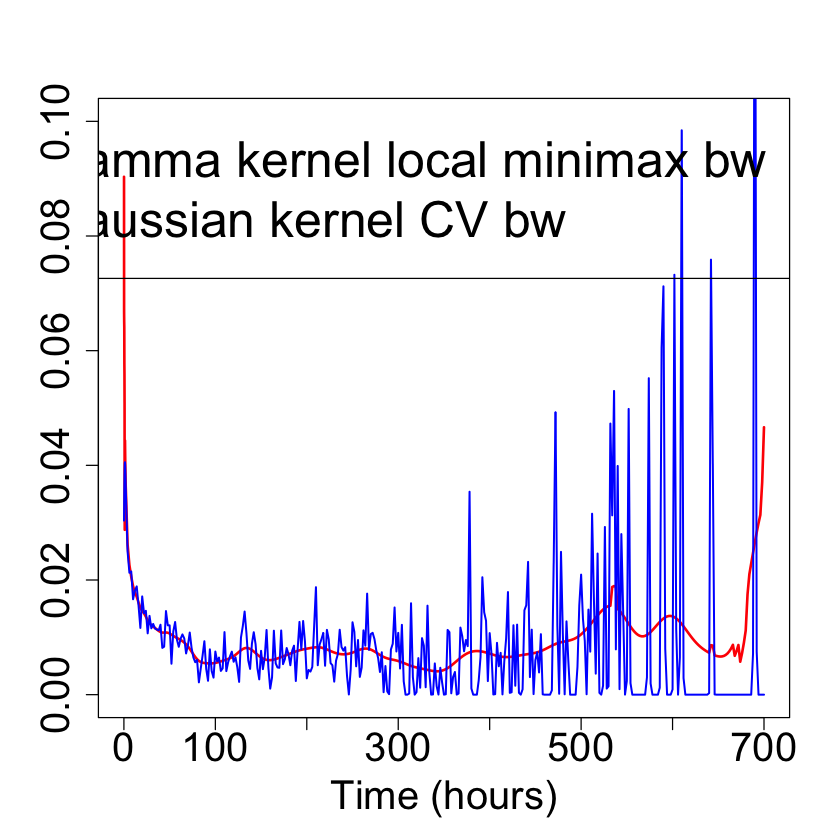

In [51]:
#Testing the adaptive hazard rate estimator on real data (smurf flies)

# plot figure 5 

#pdf(file = "Oracle_smurf.pdf",  width = 15, height = 7.5) 

Grid_exp = c((1:20)/10, (2:350)*2 ) 
RES = minimax_pointwise_data(sort(TS),Grid_exp) #local minimax estimator

par(cex.lab = 2, cex.axis = 2, cex.main = 2)

Kopt = RES$K #adaptive bandwidth estimator
Bopt = RES$B #chosen bandwidths 
B = Bandwidth_set(length(TS))
CV_sm=crossval(sort(TS),(1:40)/5,ker_estg,0)#computing CV for each bandwidth in the set
b_exp = which.min(CV_sm)/5 #CV bandwidth 
est_gaus_exp = sapply(Grid_exp, function(t)(ker_estg(t,TS,b_exp))) #gaussian kernel estimator  
cat('CV bandwidth:',b_exp,'\n')                      
cat('Maximum of the gaussian estimator with CV bw near 0:',max(est_gaus_exp[0:10]),'\n')
cat('Maximum of the gamma estimator with minimax local bw near 0:',max(Kopt[0:10]))

#layout(matrix(c(1,2), 1, 2, byrow = TRUE))
plot(Grid_exp,Kopt, type = 'l',col='red',lwd=2.1,lty=1,ylim=c(0,0.1),xlab = 'Time (hours)',ylab = NA)
lines(Grid_exp,est_gaus_exp, type = 'l', col='blue' ,lwd=1.6)
legend('topright',legend=c('Gamma kernel local minimax bw','Gaussian kernel CV bw'), col=c('red','blue'),lwd=2,cex=2.5)
if(FALSE){
test = sapply(Grid_exp, function(t)(ker_est_gamma_c(t,TS,min(B))))
plot(Grid_exp,  test, col='purple',lty=1,lwd=2,type = 'l',ylim=c(0,0.1),xlab = 'Time (hours)',ylab = NA)   
test = sapply(Grid_exp, function(t)(ker_est_gamma_c(t,TS,max(B))))
lines(Grid_exp,  test, col='black',lty=1,lwd=2,type = 'l',ylim=c(0,0.1),xlab = 'Time (hours)',main = 'Maximum bandwidth',ylab = NA)  
legend('topright',legend=c('Gamma kernel min bw','Gamma kernel max bw'), col=c('purple','black'),lwd=2,cex=2.5)
}
#dev.off()             


# Appendix (Figure 6)

In [58]:
#estimators for m = 500 (Figure 6.a)
BW_CV = (1:150)/3 #set of bandwidths for cross validation
Grid = 0:600
m=500
seed = 1

pop_init <- population(data.frame( birth = rep(0, m), death = NA))

# Exponential hazard rate 
sim_out <- popsim(model = model_death, initial_population = pop_init,
                    events_bounds = c('death' = a+b),
                    parameters = param,
                    time = 2000, seed=seed)

data_500 = sim_out$population$death
B5 = Bandwidth_set_global(m) #bandwith set for global minimax bandwidth choice
RES5 = minimax_global(data_500,  Grid, B5)#global minimax bandwidth estimator
Bopt_5= RES5$B #chosen bandwidth

CV5 =crossval(sort(data_500),BW_CV,ker_est_gamma_c,0)#cross validation for gamma kernel
Bopt_cv5 = BW_CV[which.min(CV5)]#minmizer of cross-validation
res_adapt5 = sapply(Grid, function(t)(ker_est_gamma_c(t,data_500,Bopt_5))) #minimax global bandwidth choice estimator
res_CV5 = sapply(Grid, function(t)(ker_est_gamma_c(t,data_500,Bopt_cv5))) #cross-validation bandiwdth estimator

B1 = Bandwidth_set(m)
RES = minimax_pointwise(data_500 ,Grid, B1,seed)#local minimax bandwidth estimator
Kopt1 = RES$K #adaptive hazard estimator
Bopt1 = RES$B #chosen bandwidth

est_band1 = sapply(Grid, function(x)( ker_est_neigh(x,data_500,25))) #nearest neighbour bandwidth gaussian kernel estimator 

In [59]:
#estimators for m = 2000 (Figure 6.b)
BW_CV = (1:150)/3 #set of bandwidths for cross validation

m=2000 

pop_init <- population(data.frame( birth = rep(0, m), death = NA))

# Exponential hazard rate 
sim_out <- popsim(model = model_death, initial_population = pop_init,
                    events_bounds = c('death' = a+b),
                    parameters = param,
                    time = 2000, seed=seed)
data_2000 = sim_out$population$death
B2 = Bandwidth_set_global(m)
RES2 = minimax_global(data_2000,  Grid, B2)
Bopt_2= RES2$B #chosen bandwidth

CV2 =crossval(sort(data_2000),BW_CV,ker_est_gamma_c,0)
Bopt_cv2 = BW_CV[which.min(CV2)]
res_adapt2 = sapply(Grid, function(t)(ker_est_gamma_c(t,data_2000,Bopt_2)))
res_CV2 = sapply(Grid, function(t)(ker_est_gamma_c(t,data_2000,Bopt_cv2)))

B3 = Bandwidth_set(m)
RES2 = minimax_pointwise(data_2000,  Grid, B3)
Kopt3 = RES2$K
Bopt3 = RES2$B

est_band3 = sapply(Grid, function(x)( ker_est_neigh(x,data_2000,60))) #nearest neighbour bandwidth gaussian kernel estimator

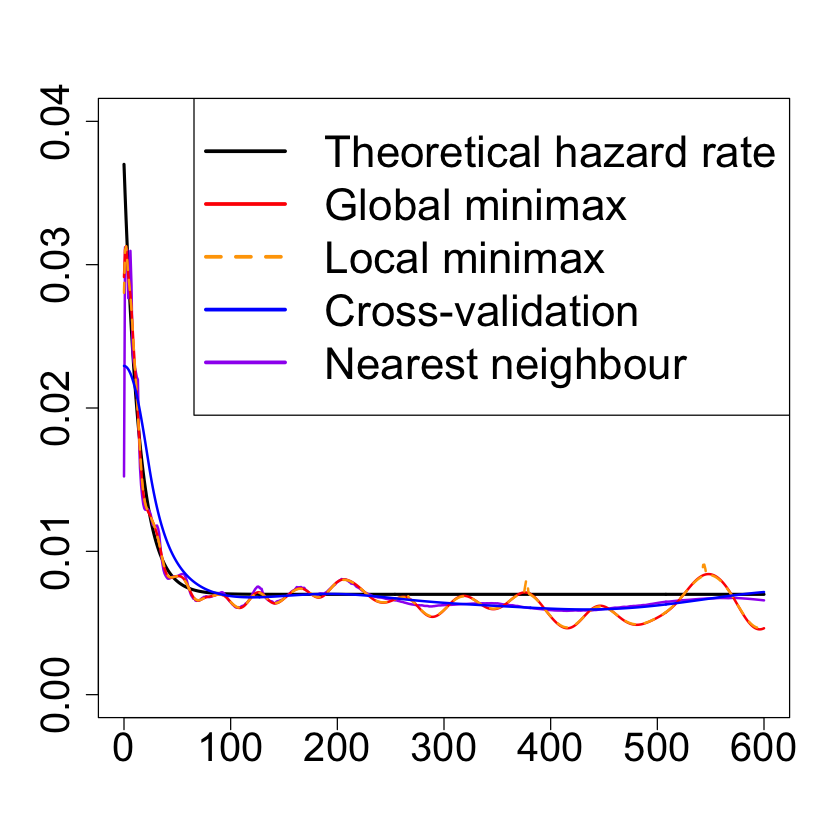

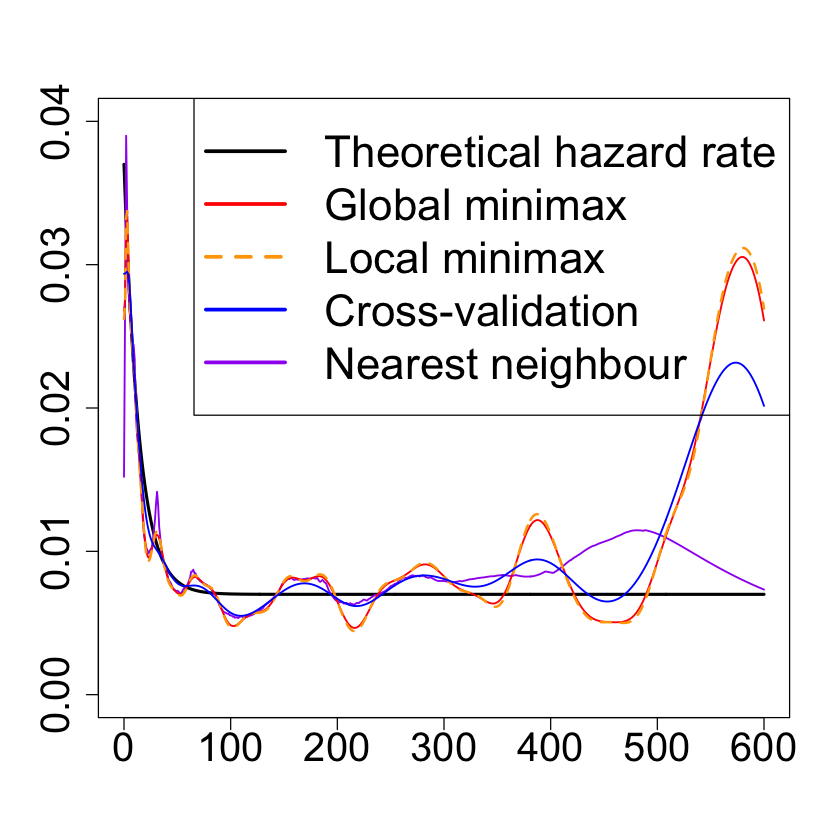

In [60]:
#Plots of the estimators
#pdf(file = "bw_choice_comp2000.pdf",  width = 10, height = 10)  
par(cex.lab = 2, cex.axis = 2,cex.main = 2)
              
plot(Grid,th_haz,type = 'l',col='black',lwd=2.5,ylim = c(0,0.04),xlab = NA, ylab = NA)
lines(Grid, est_band3,lwd=2, col='purple')
lines(Grid,res_adapt2,col='red',type='l',ylim=c(0,0.04),lwd=2)
lines(Grid, Kopt3,type = 'l',col='orange',lty=2,lwd=2)
lines(Grid,res_CV2,lwd=2,col='blue')

legend('topright',legend=c('Theoretical hazard rate','Global minimax',
                           'Local minimax', 'Cross-validation', 'Nearest neighbour'),
        col=c('black','red','orange','blue','purple'), pch=c(NA,NA,NA,NA,NA),lty = c(1,1,2,1,1),lwd=3,cex=2.2)
            
#dev.off()
                
#pdf(file = "bw_choice_comp500.pdf",  width = 10, height = 10)  
par(cex.lab = 2, cex.axis = 2,cex.main = 2)

plot(Grid,th_haz,type = 'l',col='black',lwd=2.5,ylim = c(0,0.04),xlab = NA, ylab = NA)
lines(Grid, est_band1,lwd=1.5, col='purple')
lines(Grid,res_adapt5,col='red',type='l',ylim=c(0,0.08),lwd=1.5)
lines(Grid, Kopt1,type = 'l',col='orange',lty=2,lwd=2)
lines(Grid,res_CV5,lwd=1.5,col='blue')

legend('topright',legend=c('Theoretical hazard rate','Global minimax',
                           'Local minimax', 'Cross-validation', 'Nearest neighbour'),
        col=c('black','red','orange','blue','purple'), pch=c(NA,NA,NA,NA,NA),lty = c(1,1,2,1,1),lwd=3,cex=2.2)
#dev.off()      